In [9]:
%matplotlib inline

import h5py
import numpy as np
from matplotlib import pyplot as plt
import hdf5storage
import glob

The CMRxRecon dataset is distributed as a set of HDF5 files and can be read with the h5py package. Here, we first show how to open a file from the multi-coil dataset. Each file corresponds to ntime * nslice of MRI scan and contains the k-space data.

In [39]:
file_names = glob.glob('/csiNAS3/mridata/CMRxRecon/TrainingSet/**/**lax**.mat')
file_name = file_names[0]
print(file_name)
hf_m = h5py.File(file_name)

# here to load the kspace data
newvalue = hf_m['Recon_ks']
fullmulti = newvalue["real"] + 1j*newvalue["imag"]

/csiNAS3/mridata/CMRxRecon/TrainingSet/P017/cine_lax_ks.mat


In [40]:
# grab corresponding calibration data
file_name = file_names[0].replace('cine_lax_ks.mat','cine_lax_calib.mat')
print(file_name)

hf_calib = h5py.File(file_name)
# print(hf_calib.keys())
# # here to load the kspace data
newvalue_calib = hf_calib['Calib']
fullcalib = newvalue_calib["real"] + 1j*newvalue_calib["imag"]

/csiNAS3/mridata/CMRxRecon/TrainingSet/P017/cine_lax_calib.mat


In [41]:
[nframe, nslice, ncoil, ny, nx] = fullmulti.shape
print(nframe, nslice, ncoil, ny, nx)

fullcalib = sp.resize(fullcalib, (nframe, nslice, ncoil, ny, nx))

25 3 30 204 448


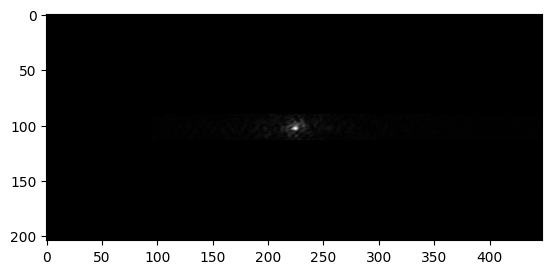

In [42]:
time = 10
slice = 1
plt.figure()
plt.imshow(np.abs(fullcalib[time,slice,0,...]), cmap='gray')

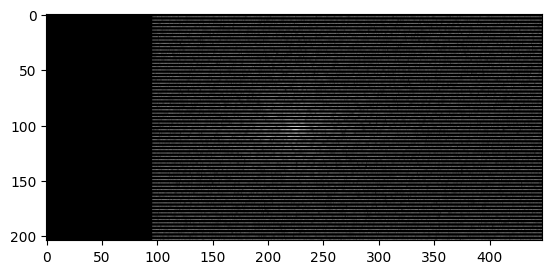

In [43]:
plt.figure()
plt.imshow(abs(fullmulti[time,slice,0,...])**.2, cmap='gray')

In multi-coil MRIs, k-space has the following shape: 

#number of frame, number of slices, number of coils, ny, nx (ny is the phase encoding direction for undersampling)

For single-coil MRIs, k-space has the following shape: #number of frame, number of slices, ny, nx


In [44]:
# esprit calibration
import sigpy as sp
from sigpy.mri.app import EspiritCalib

espirit_maps = EspiritCalib(fullcalib[time,slice,...], calib_width=24, kernel_width=6, thresh=0.02, crop=0.9, show_pbar=True).run()

EspiritCalib: 100%|██████████| 100/100 [00:11<00:00,  8.74it/s]


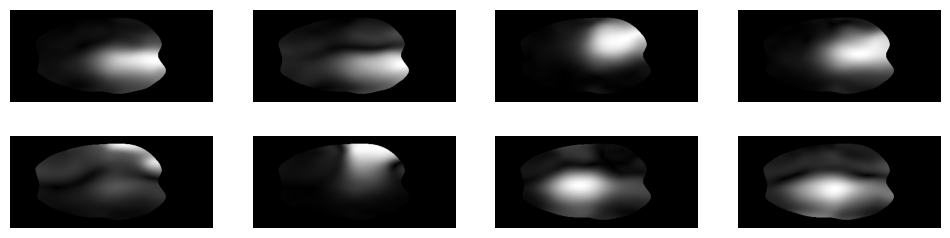

In [45]:
plt.figure(figsize=(12,3))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(np.abs(espirit_maps[i,...]), cmap='gray')
    plt.axis('off')

In [46]:
replace_calib_to_full = False

if replace_calib_to_full:
    #replace central kspace of fullmulti with fullcalib
    all_data = fullmulti.copy()
    all_data[:,:,:,ny//2-12:ny//2+12,:] = fullcalib[:,:,:,ny//2-12:ny//2+12,:]
else:
    all_data = fullmulti.copy()


sense_recon = sp.mri.app.SenseRecon(all_data[time,slice], espirit_maps, lamda=0.01)
sense_gt_img = sense_recon.run()



SenseRecon: 100%|██████████| 100/100 [00:18<00:00,  5.35it/s, resid=1.26E-15]


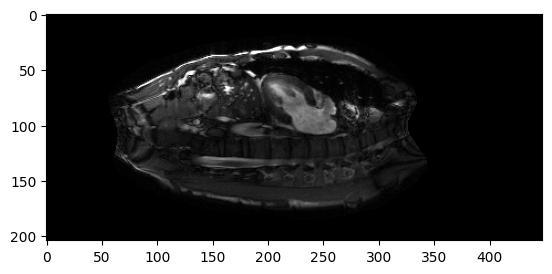

: 

In [ ]:
plt.figure()
plt.imshow(np.abs(sense_gt_img), cmap='gray',vmax = 0.5*np.max(np.abs(sense_gt_img)))

## load precomputed images

In [159]:
import torch
import matplotlib.pyplot as plt
cont = torch.load('/csiNAS3/mridata/CMRxRecon/train_videos/cine_sax_001.pt', weights_only=False)
gt_imgs = cont['gt_imgs']
print(gt_imgs.shape)

(18, 10, 204, 512)


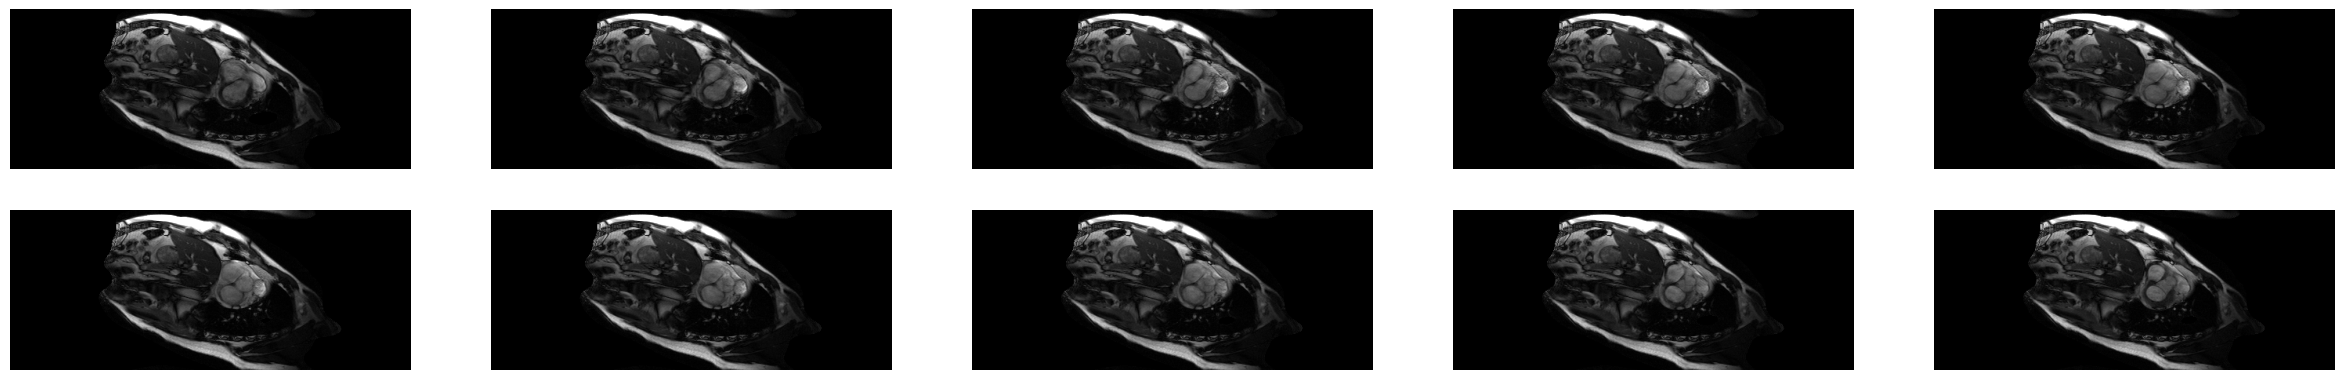

In [160]:
plt.figure(figsize=(30,10))
for time in range(10):
    plt.subplot(4,5,time+1)
    plt.imshow(np.abs(gt_imgs[time,0,...]), cmap='gray',vmax = 0.5*np.max(np.abs(gt_imgs[time,0,...])))
    plt.axis('off')

In [ ]:
# create a video
import cv2
height, width = gt_imgs.shape[2], gt_imgs.shape[3]
video = cv2.VideoWriter('/home/blevac/cmr-data/cine_sense.avi', cv2.VideoWriter_fourcc(*'DIVX'), 5, (width, height))
for time in range(18):
    frame = (np.abs(gt_imgs[time,0,...])/np.max(np.abs(gt_imgs[time,0,...]))*255).astype(np.uint8)
    frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
    video.write(frame)
video.release()

## Convert vids to mp4

In [5]:
import torch
import matplotlib.pyplot as plt
import glob
import sigpy as sp
import cv2
import numpy as np
all_volumes = glob.glob('/csiNAS3/mridata/CMRxRecon/train_videos/*.pt')
print(len(all_volumes))

for vol in all_volumes:
    cont = torch.load(vol, weights_only=False)
    gt_imgs = cont['gt_imgs']
    print(gt_imgs.shape)

15
(16, 3, 204, 448)
(27, 10, 246, 512)
(21, 3, 204, 448)
(25, 11, 246, 512)
(25, 3, 168, 448)
(18, 10, 204, 512)
(24, 3, 168, 448)
(27, 3, 204, 448)
(21, 11, 204, 512)
(4, 20, 132, 448)
(15, 10, 162, 512)
(22, 9, 204, 512)
(19, 3, 204, 448)
(25, 10, 246, 512)
(23, 3, 168, 448)


In [6]:

for vol in all_volumes:
    cont = torch.load(vol, weights_only=False)
    gt_imgs = cont['gt_imgs']
    # print(gt_imgs.shape)
    for slice in range(gt_imgs.shape[1]):
        # create a video
        gt_imgs = sp.resize(gt_imgs, (25, gt_imgs.shape[1], 246, 512))
        height, width = gt_imgs.shape[2], gt_imgs.shape[3]
        video = cv2.VideoWriter('/home/blevac/cmr-data/train_data/'+vol.split('/')[-1].replace('.pt','_slice'+str(slice)+'.mp4'), cv2.VideoWriter_fourcc(*'mp4v'), 5, (width, height))
        for time in range(gt_imgs.shape[0]-1):
            frame = (np.abs(gt_imgs[time,slice,...])/np.max(np.abs(gt_imgs[time,slice,...]))*255).astype(np.uint8)
            frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
            video.write(frame)
        video.release()

/tmp/ipykernel_1752305/1041569160.py:11: RuntimeWarning: invalid value encountered in divide
  frame = (np.abs(gt_imgs[time,slice,...])/np.max(np.abs(gt_imgs[time,slice,...]))*255).astype(np.uint8)
/tmp/ipykernel_1752305/1041569160.py:11: RuntimeWarning: invalid value encountered in cast
  frame = (np.abs(gt_imgs[time,slice,...])/np.max(np.abs(gt_imgs[time,slice,...]))*255).astype(np.uint8)


In [7]:
# create a single csv which has .mp4 name and text "mri" for each line
import torch
import matplotlib.pyplot as plt
import glob
import sigpy as sp
import cv2
import numpy as np

all_videos = glob.glob('/csiNAS3/mridata/CMRxRecon/train_videos/*.pt')
print(len(all_videos))

with open('/home/blevac/cmr-data/train_data/train_data.csv', 'w') as f:
    f.write('video,prompt\n')
    for vol in all_videos:
        cont = torch.load(vol, weights_only=False)
        gt_imgs = cont['gt_imgs']
        # print(gt_imgs.shape)
        for slice in range(gt_imgs.shape[1]):
            video_name = vol.split('/')[-1].replace('.pt','_slice'+str(slice)+'.mp4')
            # put video_name in first column and "mri" in second column
            f.write(video_name + ',mri\n')
## load precomputed images


15
